In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import glob

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import BinaryCrossentropy

import sklearn 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

from HigherTier import HigherTierModel
from HigherTier import PerformanceFuncs

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
#trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_*.npz')
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_2_shower.npz')
print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_2_shower.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

nEpochs = 10
batchSize = 64
learningRate = 1e-3

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 7))
variables_test = np.empty((0, 7))
# Training cut
trainingCutDCA_train = np.empty((0), dtype='float')
trainingCutDCA_test = np.empty((0), dtype='float')
# Truth
y_train = np.empty((0))
y_test = np.empty((0))
isTruePrimaryLink_train = np.empty((0), dtype='int')
isTruePrimaryLink_test = np.empty((0), dtype='int')

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Training cut
    trainingCutDCA_train = np.concatenate((trainingCutDCA_train, data['trainingCutDCA_train']), axis=0)
    trainingCutDCA_test = np.concatenate((trainingCutDCA_test, data['trainingCutDCA_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)
    isTruePrimaryLink_train = np.concatenate((isTruePrimaryLink_train, data['isTruePrimaryLink_train']), axis=0)
    isTruePrimaryLink_test = np.concatenate((isTruePrimaryLink_test, data['isTruePrimaryLink_test']), axis=0)                                             

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_2_shower.npz , This may take a while...


In [5]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trainingCutDCA_train.shape:', trainingCutDCA_train.shape)
print('trainingCutDCA_test.shape:', trainingCutDCA_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

variables_train.shape: (211447, 7)
variables_test.shape: (23495, 7)
y_train.shape: (211447,)
y_test.shape: (23495,)
trainingCutDCA_train.shape: (211447,)
trainingCutDCA_test.shape: (23495,)
isTruePrimaryLink_train.shape: (211447,)
isTruePrimaryLink_test.shape: (23495,)


In [6]:
###########################################################
# Apply training cut topology mask
###########################################################

# These are inspired by hand-scanning :'(
MAX_TRAINING_CUT_DCA = 50.0

######################
# training set first
######################
# Make mask
passTrainingCutDCA_train = trainingCutDCA_train < MAX_TRAINING_CUT_DCA
passTrainingCuts_train = passTrainingCutDCA_train

# Mask the 1D variables... shape=(nEntries, )
y_train = y_train[passTrainingCuts_train]
trainingCutDCA_train = trainingCutDCA_train[passTrainingCuts_train]
isTruePrimaryLink_train = isTruePrimaryLink_train[passTrainingCuts_train]

# Mask the variable... shape=(nEntries, nVariables)
variables_train = variables_train[[[entry] * nVariables for entry in passTrainingCuts_train]].reshape(-1, nVariables)

######################
# now test set
######################
# Make mask
passTrainingCutDCA_test = trainingCutDCA_test < MAX_TRAINING_CUT_DCA
passTrainingCuts_test = passTrainingCutDCA_test

# Mask the 1D variables... shape=(nEntries, )
y_test = y_test[passTrainingCuts_test]
trainingCutDCA_test = trainingCutDCA_test[passTrainingCuts_test]
isTruePrimaryLink_test = isTruePrimaryLink_test[passTrainingCuts_test]

# Mask the variable... shape=(nEntries, nVariables)
variables_test = variables_test[[[entry] * nVariables for entry in passTrainingCuts_test]].reshape(-1, nVariables)

In [7]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trainingCutDCA_train.shape:', trainingCutDCA_train.shape)
print('trainingCutDCA_test.shape:', trainingCutDCA_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

print('')
print('ntrain:', ntrain)
print('ntest:', ntest)

variables_train.shape: (160255, 7)
variables_test.shape: (17825, 7)
y_train.shape: (160255,)
y_test.shape: (17825,)
trainingCutDCA_train.shape: (160255,)
trainingCutDCA_test.shape: (17825,)
isTruePrimaryLink_train.shape: (160255,)
isTruePrimaryLink_test.shape: (17825,)

ntrain: 160255
ntest: 17825


In [8]:
###########################################################
# Define model and optimiser and compile the model
###########################################################

model = HigherTierModel.PrimaryShowerFinalOutputModel(nVariables)
optimiser = optimizers.legacy.Adam(learning_rate=learningRate)
model.compile(optimizer=optimiser, metrics=['accuracy'], loss=['binary_crossentropy'])

In [9]:
###########################################################
# Define class weights
###########################################################

nTrue_final = np.count_nonzero(isTruePrimaryLink_train == 1)
nBackground_final = np.count_nonzero(isTruePrimaryLink_train == 0)

maxLinks = max(nTrue_final, nBackground_final)

classWeights_final = {0: maxLinks/nBackground_final, 1: maxLinks/nTrue_final}

print('nTrue_final:', nTrue_final)
print('nBackground_final:', nBackground_final)
print('classWeights_final:', classWeights_final)

nTrue_final: 121001
nBackground_final: 39254
classWeights_final: {0: 3.082513883935395, 1: 1.0}


In [10]:
###########################################################
# Fit the model
###########################################################

filePath_final = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower'
    
# checkpoint
checkpoint_final = ModelCheckpoint(filePath_final, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list_final = [checkpoint_final, reduce_lr_final]

history_final = model.fit(variables_train, isTruePrimaryLink_train, validation_data=(variables_test, isTruePrimaryLink_test), 
                          batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list_final, class_weight=classWeights_final)

Epoch 1/10
2399/2504 [===========================>..] - ETA: 0s - loss: 0.9562 - accuracy: 0.6319
Epoch 1: val_accuracy improved from -inf to 0.59574, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2504/2504 [==============================] - 1s 466us/step - loss: 0.9537 - accuracy: 0.6303 - val_loss: 0.5979 - val_accuracy: 0.5957 - lr: 0.0010
Epoch 2/10
2402/2504 [===========================>..] - ETA: 0s - loss: 0.8859 - accuracy: 0.6111
Epoch 2: val_accuracy improved from 0.59574 to 0.62553, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2504/2504 [==============================] - 1s 424us/step - loss: 0.8852 - accuracy: 0.6123 - val_loss: 0.5838 - val_accuracy: 0.6255 - lr: 0.0010
Epoch 3/10
2411/2504 [===========================>..] - ETA: 0s - loss: 0.8597 - accuracy: 0.6713
Epoch 3: val_accuracy improved from 0.62553 to 0.70530, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2504/2504 [==============================] - 1s 423us/step - loss: 0.8591 - accuracy: 0.6722 - val_loss: 0.5642 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 4/10
2425/2504 [============================>.] - ETA: 0s - loss: 0.8428 - accuracy: 0.7157
Epoch 4: val_accuracy improved from 0.70530 to 0.72404, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2504/2504 [==============================] - 1s 421us/step - loss: 0.8429 - accuracy: 0.7159 - val_loss: 0.5600 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 5/10
2416/2504 [===========================>..] - ETA: 0s - loss: 0.8327 - accuracy: 0.7319
Epoch 5: val_accuracy improved from 0.72404 to 0.74020, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2504/2504 [==============================] - 1s 454us/step - loss: 0.8327 - accuracy: 0.7321 - val_loss: 0.5538 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 6/10
2420/2504 [===========================>..] - ETA: 0s - loss: 0.8263 - accuracy: 0.7417
Epoch 6: val_accuracy improved from 0.74020 to 0.75192, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2504/2504 [==============================] - 1s 421us/step - loss: 0.8259 - accuracy: 0.7418 - val_loss: 0.5470 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 7/10
2420/2504 [===========================>..] - ETA: 0s - loss: 0.8210 - accuracy: 0.7486
Epoch 7: val_accuracy improved from 0.75192 to 0.75742, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2504/2504 [==============================] - 1s 422us/step - loss: 0.8208 - accuracy: 0.7489 - val_loss: 0.5424 - val_accuracy: 0.7574 - lr: 0.0010
Epoch 8/10
2386/2504 [===========================>..] - ETA: 0s - loss: 0.8176 - accuracy: 0.7529
Epoch 8: val_accuracy improved from 0.75742 to 0.75815, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2504/2504 [==============================] - 1s 447us/step - loss: 0.8169 - accuracy: 0.7536 - val_loss: 0.5440 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 9/10
2399/2504 [===========================>..] - ETA: 0s - loss: 0.8137 - accuracy: 0.7580
Epoch 9: val_accuracy improved from 0.75815 to 0.76191, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2504/2504 [==============================] - 1s 415us/step - loss: 0.8137 - accuracy: 0.7579 - val_loss: 0.5427 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 10/10
2418/2504 [===========================>..] - ETA: 0s - loss: 0.8120 - accuracy: 0.7592
Epoch 10: val_accuracy improved from 0.76191 to 0.76213, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


2504/2504 [==============================] - 1s 421us/step - loss: 0.8121 - accuracy: 0.7592 - val_loss: 0.5423 - val_accuracy: 0.7621 - lr: 1.0000e-04


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


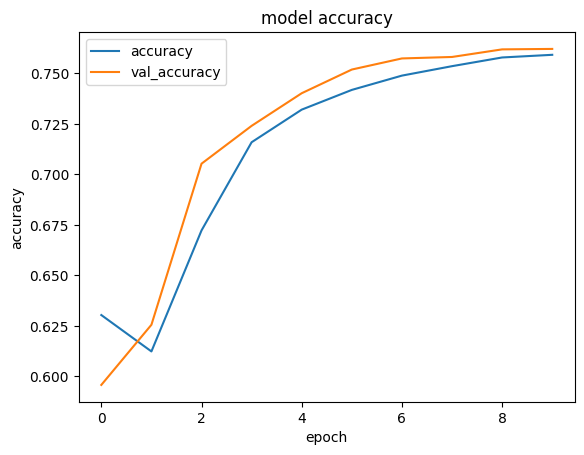

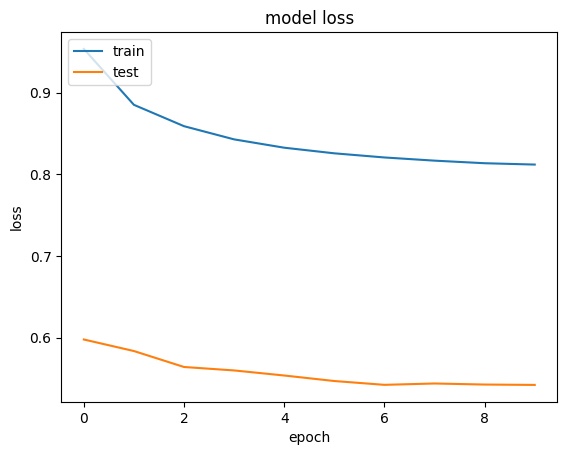

In [11]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history_final.history.keys())

# summarize history for accuracy
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_final_train = model.predict(variables_train)
y_pred_final_test = model.predict(variables_test)

558/558 [==============================] - 0s 249us/step


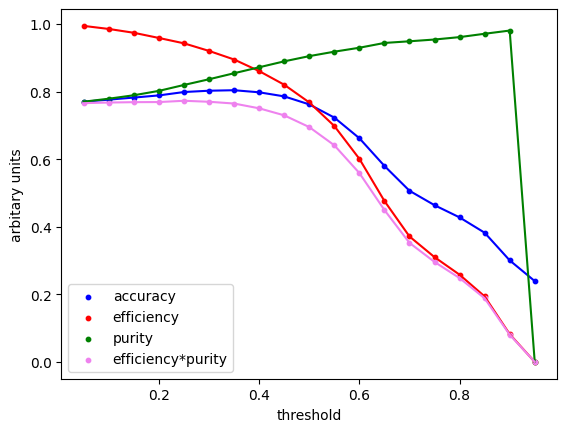

optimal_threshold_metric: 0.25


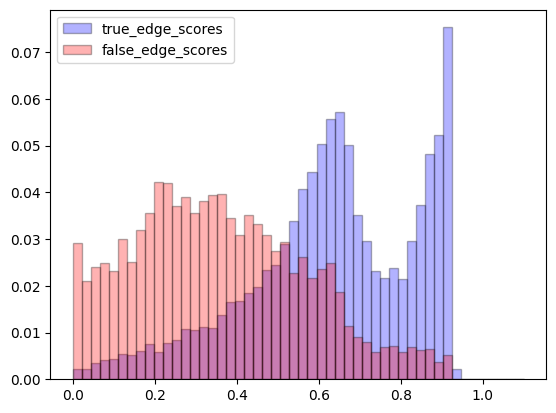

[[ 3172  1093]
 [ 3147 10413]]
[[ 1453  2812]
 [  775 12785]]


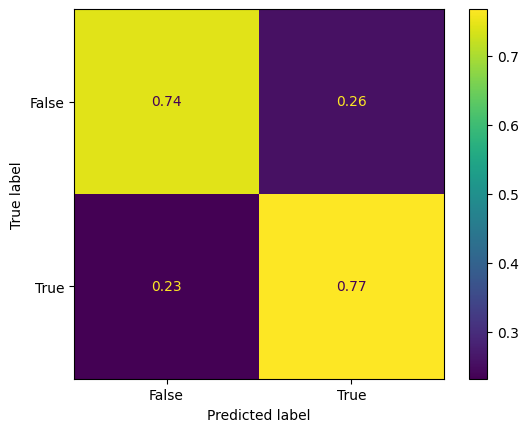

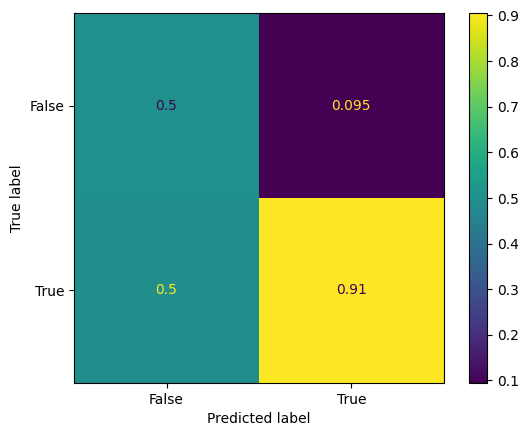

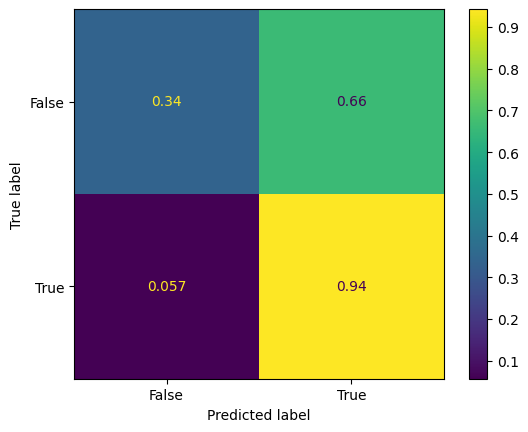

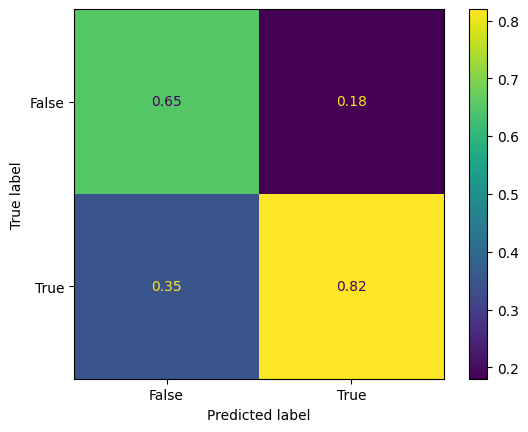

In [13]:
#######################################
# Plot final link prediction
#######################################

optimal_threshold, max_accuracy, optimal_threshold_metric, max_metric = PerformanceFuncs.calculate_accuracy(y_pred_final_test, isTruePrimaryLink_test)

print('optimal_threshold_metric:', optimal_threshold_metric)

PerformanceFuncs.plot_scores(y_pred_final_test, isTruePrimaryLink_test)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, isTruePrimaryLink_test, 0.5)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, isTruePrimaryLink_test, optimal_threshold_metric)
